## Homework1

In [20]:
library(tree)
library(rpart)
library(caTools)
library(rpart.plot)
library(kernlab)

### "Spam" Data Set

After loading the spam data set, the aim is build a tree model to learn and predict whether a mail is spam or not. The data set consists of 4601 observations. The output variable is the "type" column. "type" is a categorical variable with two levels "spam" and "nonspam". So, the model will be a classifaction tree.

In [2]:
data("spam", package = "kernlab")
nrow(spam)
class(spam$type)
levels(spam$type)

[1] 4601

[1] "factor"

[1] "nonspam" "spam"

### a) Train and Test Data Sets

In [3]:
nrow(spam[spam$type=="spam",])/nrow(spam)

[1] 0.3940448

- Positive class is "spam" since the model tries to filter the spam mails. The proportion of the spam mails is 0.394, thus there is enough observations to the model to learn, oversampling is not needed. However, the proportion of the positive class should stay constant while splitting into train and test sets. "sample.split" function from the "caTools" library can split the data set while preserving the proportion of the classes.

In [4]:
set.seed(1000)
train <- sample.split(spam$type,0.7)
spam_train <- spam[train,]
spam_test <- spam[!train,]
print("Number of observations in the training set")
nrow(spam_train)
print("Number of observations in the test set")
nrow(spam_test)
print("Proportions")
print("Train")
nrow(spam_train[spam_train$type=="spam",])/nrow(spam_train)
print("Test")
nrow(spam_test[spam_test$type=="spam",])/nrow(spam_test)

[1] "Number of observations in the training set"


[1] 3221

[1] "Number of observations in the test set"


[1] 1380

[1] "Proportions"
[1] "Train"


[1] 0.393977

[1] "Test"


[1] 0.3942029

### b) Large tree with "rpart"

In [5]:
spam_rpart <- rpart(type~.,method="class",data=spam_train,minbucket=1,minsplit=2, cp=0.0001)
cp_df <- data.frame(spam_rpart$cptable)
tail(cp_df)

,CP,nsplit,rel.error,xerror,xstd
23,0.0004728132,131,0.0338849488,0.2277384,0.01278127
24,0.0004377900,136,0.0315208826,0.2293144,0.01282104
25,0.0003940110,152,0.0244286840,0.2505910,0.01334075
26,0.0003581918,188,0.0102442868,0.2505910,0.01334075
27,0.0003377237,207,0.0031520883,0.2529551,0.01339660
28,0.0001000000,214,0.0007880221,0.2521671,0.01337802


- Using the parameters "minbucket=1", "minsplit=2" and "cp=0.0001", the largest tree is obtained with the "rpart()" function. There is 214 splits, so the tree consists of 215 leaf nodes.

### c) Predictions with large tree

In [6]:
pred_spam <- predict(spam_rpart,newdata=spam_test,type="class")
table(spam_test$type,pred_spam)

         pred_spam
          nonspam spam
  nonspam     761   75
  spam         58  486

- False positive rate = 75/836 = 0.0897
- False negative rate = 58/544 = 0.1066
- Error rate          = 133/1380 = 0.0963

### d) Cross-validation and pruning

In [7]:
index <- which.min(spam_rpart$cptable[,"xerror"])
index
min_cv <- spam_rpart$cptable[index,"xerror"] + spam_rpart$cptable[index,"xstd"]
min_cv

20 
20

[1] 0.2267775

- Summation of the minimum cross-validation error and its standart deviation is 0.226.

In [8]:
cp_df[15,]
cp_df[cp_df$xerror <= min_cv,]

,CP,nsplit,rel.error,xerror,xstd
15,0.002364066,27,0.144208,0.2301024,0.01284086


,CP,nsplit,rel.error,xerror,xstd
16,0.0021013922,31,0.13475177,0.2253743,0.01272126
17,0.0015760441,34,0.12844760,0.2253743,0.01272126
18,0.0011820331,48,0.10638298,0.2159180,0.01247695
19,0.0010244287,54,0.09929078,0.2167061,0.01249757
20,0.0009193591,64,0.08904649,0.2143420,0.01243555
21,0.0007880221,70,0.08353034,0.2206462,0.01259997
22,0.0005253480,127,0.03624901,0.2206462,0.01259997


- At the 16th row of the cp table, cv error is smaller than 0.237, so best cp value could be taken as 0.0022

In [9]:
opttree <- prune(spam_rpart,cp=0.0022)
tail(opttree$cptable)

,CP,nsplit,rel error,xerror,xstd
11,0.004728132,13,0.1962175,0.2427108,0.01315190
12,0.003940110,15,0.1867612,0.2371946,0.01301720
13,0.003546099,17,0.1788810,0.2316785,0.01288036
14,0.003152088,19,0.1717888,0.2308905,0.01286063
15,0.002364066,27,0.1442080,0.2301024,0.01284086
16,0.002200000,31,0.1347518,0.2253743,0.01272126


- After the pruning, the optimum tree has 32 leaf nodes.

### e) Predicting with the "opttree"


In [10]:
opt_pred <- predict(opttree,newdata=spam_test,type="class")
table(spam_test$type,opt_pred)

         opt_pred
          nonspam spam
  nonspam     786   50
  spam         57  487

- False positive rate = 50/836 = 0.0598
- False negative rate = 57/544 = 0.1047 
- Error rate = 107/1380 = 0.0775

- After the pruning, error rate, false positive rate and false negative rate are decreased. However, the highest decrease is in the false positive rate. Worst scenario is labeling an important mail to a spam mail. So, low false positive rate is preferred.

### b2) Large tree with "tree"


In [11]:
spam_tree <- tree(type~.,spam_train,minsize=2,mincut=1,mindev=0.0001)
summary(spam_tree)


Classification tree:
tree(formula = type ~ ., data = spam_train, minsize = 2, mincut = 1, 
    mindev = 1e-04)
Variables actually used in tree construction:
 [1] "charExclamation"  "remove"           "money"            "george"          
 [5] "hp"               "capitalLong"      "free"             "your"            
 [9] "email"            "credit"           "will"             "capitalTotal"    
[13] "mail"             "direct"           "capitalAve"       "you"             
[17] "charSemicolon"    "all"              "internet"         "make"            
[21] "address"          "over"             "our"              "num1999"         
[25] "charDollar"       "re"               "technology"       "business"        
[29] "charRoundbracket" "data"             "edu"              "receive"         
[33] "hpl"              "num3d"            "report"           "num85"           
[37] "project"          "order"           
Number of terminal nodes:  187 
Residual mean deviance:  0.0009138 = 2

- With "tree()" function, the largest tree has 187 leaf nodes.

### c2) Prediction with large tree

In [12]:
pred_spam_tree <- predict(spam_tree,newdata=spam_test,type="class")
table(spam_test$type,pred_spam_tree)

         pred_spam_tree
          nonspam spam
  nonspam     775   61
  spam         46  498

- False positive rate = 61/836 = 0.0729 
- False negative rate = 46/544 = 0.0845
- Error rate = 107/1380 = 0.0775

### d2) Cross-validation and pruning

,cv_spam.size,cv_spam.dev,cv_spam.k
10,65,320,1.750000
11,48,320,2.000000
12,42,320,2.500000
13,32,316,3.000000
14,28,327,4.000000
15,26,329,4.500000
16,22,332,5.000000
17,16,332,5.666667
18,13,333,6.333333
19,12,341,9.000000


[1] "Best size"


[1] 32

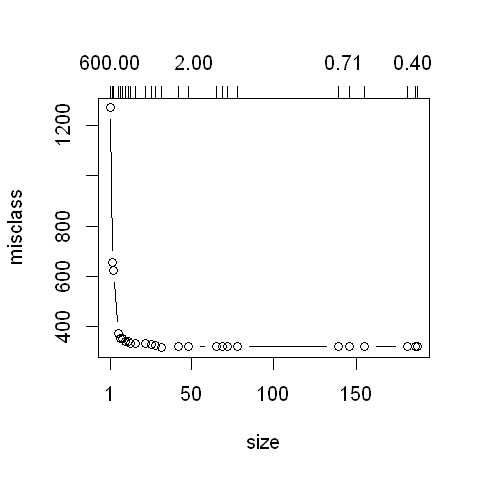

In [13]:
cv_spam <- cv.tree(spam_tree, K=10, FUN=prune.misclass)
options(repr.plot.width = 4, repr.plot.height = 4)
plot(cv_spam, type="b")
data.frame(cv_spam$size,cv_spam$dev,cv_spam$k)[10:26,]
bestsize <- cv_spam$size[which.min(cv_spam$dev)]
print("Best size")
bestsize

- In order to obtain better results, the model should use the classification error rate in the cross-validation and pruning process. "FUN = prune.misclass" parameter indicates to use classification error rate instead of the default parameter deviance. So, minimum classification error is 316 and the best tree size is 32.

In [14]:
opttree2 <- prune.tree(spam_tree,best=32)
summary(opttree2)


Classification tree:
snip.tree(tree = spam_tree, nodes = c(27L, 99L, 28L, 129L, 101L, 
521L, 256L, 21L, 261L, 776L, 389L, 18L, 98L, 19L, 257L, 20L, 
58L, 15L, 1040L, 51L, 100L, 96L, 33L))
Variables actually used in tree construction:
 [1] "charExclamation" "remove"          "money"           "george"         
 [5] "hp"              "capitalLong"     "free"            "your"           
 [9] "our"             "num1999"         "charDollar"      "re"             
[13] "capitalAve"      "you"             "business"        "edu"            
[17] "project"        
Number of terminal nodes:  32 
Residual mean deviance:  0.35 = 1116 / 3189 
Misclassification error rate: 0.0652 = 210 / 3221 

### e2) Predicting with new "opttree"

In [15]:
opt_pred2 <- predict(opttree2,newdata=spam_test,type="class")
table(spam_test$type,opt_pred2)

         opt_pred2
          nonspam spam
  nonspam     791   45
  spam         79  465

- False positive rate = 45/836 = 0.0538
- False negative rate = 79/544 = 0.1452 
- Error rate = 124/1380 = 0.0898

- While the false negative rate increases, error rate and the false positive rate is decreased. Again, the highest decrease is in the false positive rate. Spam filter shouldn't sent an importaint mail to spam box. Thus, with the lowest false positive rate 0.0538, this is the best model to use.

PS: In the compiling of cross-validation steps, a new random number is generated. Overall result isn't changing but deviance measures could have small changes in different compilings. Measurements are taken from first and same ordered compilations.